## Setup

In [1]:
import pandas as pd
import logging 
import sys
import os
sys.path.insert(0,'./src')


from src.utils.logger import sys_logger

os.makedirs("./final_data", exist_ok=True)

## Landing Zone to Staging

In [2]:
from src.utils.splitter import split_files

split_files()

[splitter.py:9]                 Files in landing zone: ['products_20241011.json', 'customer_20241009.csv', 'products_20241010.json', 'sales_20241010.txt', 'sales_20241011.txt', 'sales_20241013.txt', 'sales_20241012.txt', 'sales_20241015.txt', 'sales_20241014.txt', 'products_20241015.json', 'sales_20241009.txt', 'products_20241014.json', 'products_20241009.json', 'customer_20241015.csv', 'products_20241013.json', 'customer_20241014.csv', 'customer_20241010.csv', 'products_20241012.json', 'customer_20241011.csv', 'customer_20241013.csv', 'customer_20241012.csv']
[splitter.py:20]                products_20241011.json did not match with any source
[splitter.py:14]                customer_20241009.csv matched with customer
[splitter.py:17]                customer_20241009.csv moved to ./data/customer/
[splitter.py:20]                products_20241010.json did not match with any source
[splitter.py:20]                sales_20241010.txt did not match with any source
[splitter.py:20]          

## Staging to Tables

In [3]:
from src.utils.ingestion import run_ingestion

run_ingestion()

[watermark.py:8]                Reading watermark table from ./watermark.parquet
[watermark.py:12]               Watermark table not found at ./watermark.parquet. Creating new table
[watermark.py:14]               Watermark table has 0 rows
[ingestion.py:12]               Loading customer data
[watermark.py:18]               Getting last run date for customer
[watermark.py:21]               No previous runs found for customer
[files.py:10]                   Getting files to process from ./data/customer/
[files.py:14]                   Found 7 files to process
[ingestion.py:19]               Processing customer_20241009.csv
[files.py:26]                   Reading csv file from ./data/customer/customer_20241009.csv with kwargs {'sep': ','}
[dataframes.py:134]             Processing data for customer
[files.py:49]                   Getting saved file for customer
[files.py:18]                   Getting save filename for customer
[files.py:34]                   Reading parquet file from ./

## Report Generation

In [4]:
from matplotlib import pyplot as plt

### Customer Growth

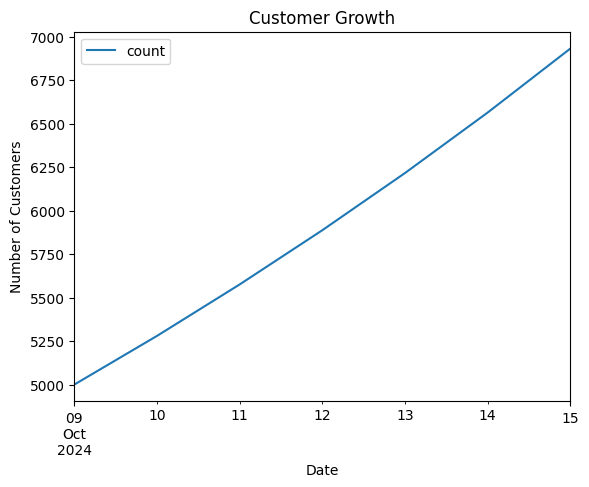

In [5]:
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()

data = []
for date in sorted(dates):
    snapshot = customers[(customers['effective_from'] <= date) & (customers['expiry_date'] > date)]
    data.append({'date': date, 'count': len(snapshot)})

df = pd.DataFrame(data)
df.plot(x='date', y='count')
plt.title('Customer Growth')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.show()

### Sales By Membership

In [6]:
# Sales By Members
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()
sales = pd.read_parquet('./final_data/sales.parquet')
merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
data = merged.groupby(['sale_date', 'membership_status'])['total_price'].sum().unstack().fillna(0)

data.plot()
plt.title('Sales by Membership Status')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './final_data/sales.parquet'

### Product Sale Breakdown

In [ ]:
# pivot of most popular products over time from members vs non-members

products = pd.read_parquet('./final_data/product.parquet')
customers = pd.read_parquet('./final_data/customer.parquet')
sales = pd.read_parquet('./final_data/sales.parquet')

merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
merged_with_products = merged.merge(products, on='product_id', how='left')
data = merged_with_products.groupby(['sale_date', 'membership_status', 'name'])['total_price'].sum().unstack().fillna(0)

data